https://www.youtube.com/watch?v=ZvsH09XGuZ0

Esta forma esta bien para entrenar los modelos basados en tensores, pero no vale para pytorch.

# 1. Descargamos las librerias necesarias para la realización del script


In [1]:
################  TRANSFORMERS ################
!pip  install transformers --quiet
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import Trainer, TrainingArguments
from transformers import Trainer
!pip install transformers[torch] --quiet
!pip install accelerate -U --quiet
################  DATASETS ################
!pip install Datasets --quiet
from datasets import DatasetDict, Dataset
# Librería para montar drive en GoogleColab y descargar el dataset que vamos a usar:
from google.colab import drive  #Montador de drive

In [2]:
import nltk
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('omw-1.4')
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from datasets import DatasetDict, Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import Trainer, TrainingArguments
from transformers import Trainer
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from google.colab import drive  #Montador de drive
from sklearn.model_selection import train_test_split
import gc

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


# 2. Importamos el dataset

In [3]:
# 1.Obtenemos de drive el dataframe con el que vamos a trabajar
drive.mount('/content/drive')
df = pd.read_csv('/content/drive/MyDrive/datasets/01 Exist2021_Esp.csv')
# Cambiamos el nombre de las columnas e eliminamos aquellas que no necesitamos:
columns_to_remove = ['test_case', 'id', 'source','language','task2']
df = df.rename(columns = {"task1": "label"}).drop(columns=columns_to_remove, axis=1)
df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,text,label
0,Nadie te va a tratar tan bien como un hombre q...,sexist
1,"@lindagisela74 Que rica putita obediente, afor...",sexist
2,@BicireporteraDF Yo lo hice a los 18 años por ...,non-sexist
3,las cosas q sueño son indicios de que yo enrea...,non-sexist
4,"Pero a la niña le gustó desde que lo vió, así ...",non-sexist


In [4]:
#Cambiamos los valores nominales de sexista y no sexista a valores numéricos
df['label'] = df['label'].replace(['non-sexist','sexist'],[0, 1])

In [5]:
#Eliminamos cualquier fila que haya podido quedar en blanco:
df = df.dropna()
df.head()

,text,label
0,Nadie te va a tratar tan bien como un hombre q...,1
1,"@lindagisela74 Que rica putita obediente, afor...",1
2,@BicireporteraDF Yo lo hice a los 18 años por ...,0
3,las cosas q sueño son indicios de que yo enrea...,0
4,"Pero a la niña le gustó desde que lo vió, así ...",0


### 2.1 - *Separamos el dataset en varios conjuntos (Train, Validación y Test)*

In [6]:
# Dividiremos el dataset en el 80% para el entrenamiento, el 10% para el proceso de validation, y un 10% para testear los resultados del modelo.
train_df, valtest_df = train_test_split(df, test_size = 0.2, random_state = 42)
val_df, test_df = train_test_split(valtest_df, test_size = 0.5, random_state = 42)
train_df.shape, val_df.shape, test_df.shape

((9063, 2), (1133, 2), (1133, 2))

In [7]:
train = Dataset.from_pandas(train_df)
validation = Dataset.from_pandas(val_df)
test = Dataset.from_pandas(test_df)

In [8]:
#Lo convertimos en un solo dataset:

TWS = DatasetDict({
  'train': train,
  'val': validation,
  'test': test})
# Dataset.from_pandas genera una columna denominada index_0 qeu debemos eliminar:

TWS = TWS.remove_columns(["__index_level_0__"])

In [9]:
TWS

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 9063
    })
    val: Dataset({
        features: ['text', 'label'],
        num_rows: 1133
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 1133
    })
})

### 3 - Descarga del modelo y su tokenizador:

In [10]:
#Especificamos el modelo a adaptar a nuestro problema:
model_ckpt = "bert-base-cased"
# y descargamos su tokenizador:
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [11]:
#Debemos definir una función para tokenizar el dataset y que sea gestionable por nuestro modelo:
def tokenizador(batch):
  return tokenizer( batch["text"], padding = True,  max_length=512, truncation = True)

In [12]:
# Para poder aplicarlo al todo el diccionario utilizaremos la función map:
TWS_Encoded = TWS.map(tokenizador, batched = True,batch_size = None )

Map:   0%|          | 0/9063 [00:00<?, ? examples/s]

Map:   0%|          | 0/1133 [00:00<?, ? examples/s]

Map:   0%|          | 0/1133 [00:00<?, ? examples/s]

In [13]:
TWS_Encoded

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 9063
    })
    val: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1133
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1133
    })
})

In [14]:
#Necesitamos que los objetos sean de tipo torch
TWS_Encoded.set_format("torch", columns = ["label","input_ids", "attention_mask"])

In [15]:
#Debemos comprobar que la ejecucion se vaya a realizar sobre cuda:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [16]:
# Definiremos un diccionario para poder traduccir las etiquetas o label que nos devuelva nuestro modelo:
Etiqueta_dato = {}
Dato_Etiqueta = {}

etiquetas = ['Sexista','No_Sexista']
for dato, nombre_etiqueta in enumerate(etiquetas):
  Dato_Etiqueta[nombre_etiqueta] = str(dato)
  Etiqueta_dato[str(dato)]= nombre_etiqueta


Etiqueta_dato , Dato_Etiqueta

({'0': 'Sexista', '1': 'No_Sexista'}, {'Sexista': '0', 'No_Sexista': '1'})

In [17]:
#Obtenemos el modelo con una cabeza de clasificación:
model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels = 2, label2id = Etiqueta_dato, id2label = Dato_Etiqueta).to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## 3.1 - Definimos las métricas de evaluación y los hiperparámetros:

In [18]:
# 1. Definimos la función de evaluación para calcular tanto el f1 como el accuracy:
def compute_metrics(pred):
  label = pred.label_ids
  preds = pred.predictions.argmax(-1)
  f1 = f1_score(label, preds, average = "weighted")
  acc = accuracy_score(label, preds)
  return {"accuracy": acc, "f1": f1}

In [19]:
#2. Definimos los hiperparametros para el entrenamiento:
#Empezamos con un batchsize y un número de épocas aleatorio:
batch_size = 8
num_epochs = 3

# Name of the model (to be uploaded to Huggingface)
model_name = f"{model_ckpt}-finetuned-taskA"

# Specify the path to store the fine-tuned model
path_model = '/content/drive/MyDrive/'

# Training argument
training_args = TrainingArguments(
  output_dir = os.path.join(path_model, model_name),
  num_train_epochs = num_epochs,
  learning_rate = 2e-5,
  per_device_train_batch_size = batch_size,
  per_device_eval_batch_size = batch_size,
  weight_decay = 0.01,
  evaluation_strategy = "epoch",
  load_best_model_at_end = True,
  push_to_hub = False,
  save_strategy = "epoch")

In [20]:
# Creamos el objeto trainer:
trainer = Trainer(
  model = model,
  args = training_args,
  compute_metrics = compute_metrics,
  train_dataset = TWS_Encoded["train"],
  eval_dataset = TWS_Encoded["val"],
  tokenizer = tokenizer)

In [21]:
gc.collect()
torch.cuda.empty_cache()

In [22]:
#5.Entrenamos nuestro modelo:
trainer.train()


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.666000,0.646046,0.658429,0.658510
2,0.564400,0.597965,0.703442,0.696014
3,0.449000,0.612867,0.725508,0.724177


Could not locate the best model at /content/drive/MyDrive/bert-base-cased-finetuned-taskA/checkpoint-2266/pytorch_model.bin, if you are running a distributed training on multiple nodes, you should activate `--save_on_each_node`.


TrainOutput(global_step=3399, training_loss=0.5634162994860621, metrics={'train_runtime': 2487.5681, 'train_samples_per_second': 10.93, 'train_steps_per_second': 1.366, 'total_flos': 7153726484183040.0, 'train_loss': 0.5634162994860621, 'epoch': 3.0})

### Matriz de Confusión

In [23]:
preds_output = trainer.predict(TWS_Encoded["val"])

In [24]:
preds_output.metrics

{'test_loss': 0.6128674745559692,
 'test_accuracy': 0.7255075022065314,
 'test_f1': 0.724177358078489,
 'test_runtime': 15.3153,
 'test_samples_per_second': 73.978,
 'test_steps_per_second': 9.272}

Text(0.5, 1.0, 'Matriz de confusión')

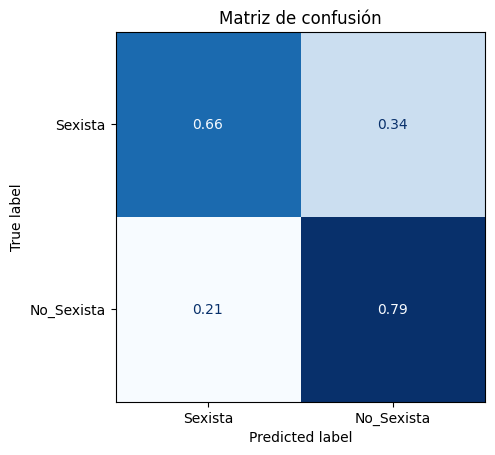

In [26]:
y_preds = np.argmax(preds_output.predictions, axis = 1)
cm = confusion_matrix(TWS_Encoded["val"]['label'], y_preds, normalize = "true")
labels = ['Sexista', 'No_Sexista']
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = labels)
disp.plot(cmap = "Blues", values_format = ".2f", colorbar = False)
plt.title("Matriz de confusión")

In [27]:
preds_output = trainer.predict(TWS_Encoded["test"])
preds_output.metrics



{'test_loss': 0.6092156171798706,
 'test_accuracy': 0.7228596646072374,
 'test_f1': 0.7211297667608348,
 'test_runtime': 21.9724,
 'test_samples_per_second': 51.565,
 'test_steps_per_second': 6.463}

Text(0.5, 1.0, 'Matriz de confusión')

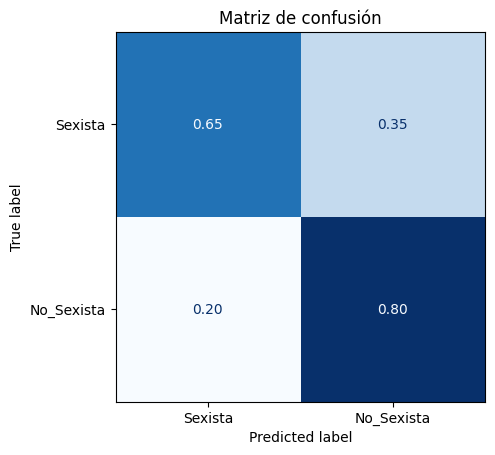

In [29]:
y_preds = np.argmax(preds_output.predictions, axis = 1)
cm = confusion_matrix(TWS_Encoded["test"]['label'], y_preds, normalize = "true")
labels = ['Sexista', 'No_Sexista']
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = labels)
disp.plot(cmap = "Blues", values_format = ".2f", colorbar = False)
plt.title("Matriz de confusión")

# Análisis del validation loss

In [30]:
#Análisis de la perdida del modelo:

from torch.nn.functional import cross_entropy

def forward_pass_with_label(batch):
    # Place all input tensors on the same device as the model
    inputs = {k:v.to(device) for k,v in batch.items()
              if k in tokenizer.model_input_names}

    with torch.no_grad():
        output = model(**inputs)
        pred_label = torch.argmax(output.logits, axis=-1)
        loss = cross_entropy(output.logits, batch["label"].to(device),
                             reduction="none")
    # Place outputs on CPU for compatibility with other dataset columns
    return {"loss": loss.cpu().numpy(),
            "predicted_label": pred_label.cpu().numpy()}

In [31]:
TWS_Encoded["val"] = TWS_Encoded["val"].map(forward_pass_with_label, batched=True, batch_size=16)

Map:   0%|          | 0/1133 [00:00<?, ? examples/s]

In [32]:
def label_int2str(label):
    return Etiqueta_dato[str(label)]

In [33]:
TWS_Encoded.set_format("pandas")
cols = ["text", "label", "predicted_label", "loss"]
df_test = TWS_Encoded["val"][:][cols]
df_test["label"] = df_test["label"].apply(label_int2str)
df_test["predicted_label"] = (df_test["predicted_label"]
                              .apply(label_int2str))

In [37]:
pd.set_option('display.max_columns', None)  # Mostrar todas las columnas
pd.set_option('display.width', None)  # Ancho de la pantalla no limitado
pd.set_option('display.max_colwidth', None)  # Mostrar el texto completo en la
df_test.sort_values("loss", ascending=False).head(20)


,text,label,predicted_label,loss
1081,"Quién les hizo tanto daño Una habla de #NiUnaMenos o #MeToo, pero a estos batos lo peor que les puede pasar es no tener ligues. Bola de pendejos. https://t.co/5RnZea5J9K",No_Sexista,Sexista,3.476580
544,Cada chica atractiva en esta aplicación es cerebro muerto,No_Sexista,Sexista,3.319230
523,Y voy por un culo así el año que viene https://t.co/n41R03x8u6,No_Sexista,Sexista,3.312496
1055,Liderando a la activista #WomensRights de Arabia Saudita #LoujainAlhathloul ha sido liberada de prisión después de unos 1.000 días de detención y en medio de la persistente presión internacional para que sea liberada.https://t.co/uOvMOSbYxl,No_Sexista,Sexista,3.285903
72,idc lo que todo el mundo dice misandry es islámico que promueve el hiyab,No_Sexista,Sexista,3.278716
360,"@RyanSPowers Sin embargo, para ser justos, si se te permite “ser una chica” Y “ser un niño” ¡también puedes hacer lo “divertido”! (Yo también me dirigiría a los Boy Scouts). Lección: Los Scouts no tienen que quejarse unos de otros cuando establecen las reglas para su propia muerte.",No_Sexista,Sexista,3.256054
440,"@NauterFuck @ElNismeado @ZoeZiacok @DarkRonny23 No pero la mayoria de los hombres lo son. Ademas yo vivo repitiendo en los comentarios que no lo son todos. Pero bueno, se agarran siempre de la misma pelotudez",No_Sexista,Sexista,3.244794
33,Sodomizar el sábado es maravilloso. Necesito a alguien(s) con quien sodomizar. https://t.co/j4UB1rHyBW,No_Sexista,Sexista,3.211734
765,"Si se hubieran molestado en sacar trajes en las que las pobres señoritas llevasen un poco más de ropa y no se notase lo que intentaban con ello, hubiera subido algún puesto más. Pero en definitiva, disfruto mucho de repetir las canciones una y otra vez 2/2 https://t.co/hPhYajVkvc",No_Sexista,Sexista,3.163995
1104,"@AdorDNI Curadas ellas y curados ellos tambiénNunca vamos a conseguir igualdad si nos ponemos a odiarnos entre géneros, tenemos que trabajar todos juntos.Justamente ésa es la palabra que aborrecen, ""trabajo"" jajajaja",No_Sexista,Sexista,3.110560


In [35]:
pd.set_option('display.max_columns', None)  # Mostrar todas las columnas
pd.set_option('display.width', None)  # Ancho de la pantalla no limitado
pd.set_option('display.max_colwidth', None)  # Mostrar el texto completo en la
df_test.sort_values("loss", ascending=True).head(10)

,text,label,predicted_label,loss
1019,Quito merece ser lo que fue. Recuperémoste la libertad y el trabajo para rescatar a la ciudad del abandono y la desidia. La @CorteConstEcu debe devolver a lo s quiteños sus derechos. #TrabajoYLibertad #DerechosYTrabajo https://t.co/qIue7KS0Gh,Sexista,Sexista,0.028029
963,man como me tiltea ver gente con i9 2080 todo eso y q le tire menos de 250fps yo tengo 260fps em estrecha con una 1050 y un i5,Sexista,Sexista,0.029267
324,"El destierro violento de personas sin hogar y sus tiendas de campaña está sucediendo en todo el país. Está sucediendo en Minneapolis durante el frígido invierno. Esto habla de la crisis nacional sin hogar impulsado por la mercantilización de la vivienda, pero también los funcionarios locales pueden detener esto. https://t.co/OdDaiJxcEv",Sexista,Sexista,0.029865
894,@MichaelsCoDub Eres mi héroe de 2020. Cuando nuestra chica terminó su grado de enfermería este año.. Ella nos compró un vale para su lugar. Espero que estamos prohibidos xxx feliz Navidad para ti y la familia x,Sexista,Sexista,0.029937
546,"@parialapsus @miseriadigna22 @blancovsky @CaamiLopez_ @excitedmambo @livewithoutt 7- naciones del mundo, ha interferido en asuntos internos de nuestro país esgrimiendo hipócritamente el argumento de la violación de los derechos (…) Negamos sinceridad y autoridad moral al imperialismo yanqui para defender los derechos humanos más allá de su frontera”.",Sexista,Sexista,0.030198
321,"En los últimos años, Rusia ha sido escenario de varios de los juicios por asesinatos en serie con más víctimas en el mundo, incluyendo un caso con 78 víctimas, y otro con 48. https://t.co/gU0tPutbdc",Sexista,Sexista,0.030490
328,"cuando deciamos q llevan yendo a saco a por Dayane durante 5 meses xq la ven fuerte y q puede con todo,pero q esta vez habian sobrepasado los limites x la situacion q esta viviendo y q iba a explotar x algun lado? teniamos razon y hoy fue el dia y NO merece y me parte el alma",Sexista,Sexista,0.030691
484,@danieldessinger @StevePieczenik (1 de 2) Él lo dio el 4 de diciembre....Vi a Jesús y a un soldado de pie uno al lado del otro en la cima de esta gran colina.Ambos mirando hacia mí y mirando hacia la hermosa luz.Jesús era un hombre enorme.Viento soplaba su túnica y su pelo.Pero yo estaba muy lejos mirándolos al fondo de la colina.,Sexista,Sexista,0.031417
776,La obligación más alta y principal del periodismo ético es servir al público. #gamergate,Sexista,Sexista,0.031911
95,El público tiene derecho a la mayor cantidad de información posible para juzgar la fiabilidad y motivaciones de las fuentes. #gamergate,Sexista,Sexista,0.032180


In [36]:
model.save_pretrained(
  os.path.join(path_model, 'BERT-finetuned-taskA'))
tokenizer.save_pretrained(
    os.path.join(path_model, 'BERT-finetuned-taskA'))

('/content/drive/MyDrive/BERT-finetuned-taskA/tokenizer_config.json',
 '/content/drive/MyDrive/BERT-finetuned-taskA/special_tokens_map.json',
 '/content/drive/MyDrive/BERT-finetuned-taskA/vocab.txt',
 '/content/drive/MyDrive/BERT-finetuned-taskA/added_tokens.json',
 '/content/drive/MyDrive/BERT-finetuned-taskA/tokenizer.json')

## Prueba para verificar clasificación de categorías:

In [ ]:
#Obtenemos de drive el dataframe con el que vamos a trabajar
drive.mount('/content/drive')
df2 = pd.read_csv('/content/drive/MyDrive/Datasets a limpio /EXIST 2021 dataset_esp.csv')
# Cambiamos el nombre de las columnas e eliminamos aquellas que no necesitamos:
columns_to_remove = ['test_case', 'id', 'source','language','task1']
df2 = df2.rename(columns = {"task2": "label"}).drop(columns=columns_to_remove, axis=1)
df2.head()

In [ ]:
valores_unicos = df2['label'].unique()
print(valores_unicos)


In [ ]:
#Cambiamos los valores nominales de sexista y no sexista a valores numéricos
df2['label'] = df2['label'].replace(['non-sexist','sexual-violence', 'stereotyping-dominance',
 'misogyny-non-sexual-violence' ,'ideological-inequality', 'objectification'],[0,1,2,3,4,5])

In [ ]:
df2.head()

In [ ]:
# Definiremos un diccionario para poder traduccir las etiquetas o label que nos devuelva nuestro modelo:
Etiqueta_dato = {}
Dato_Etiqueta = {}

etiquetas = ['non-sexist','sexual-violence', 'stereotyping-dominance',
 'misogyny-non-sexual-violence' ,'ideological-inequality', 'objectification']
for dato, nombre_etiqueta in enumerate(etiquetas):
  Dato_Etiqueta[nombre_etiqueta] = str(dato)
  Etiqueta_dato[str(dato)]= nombre_etiqueta


Etiqueta_dato , Dato_Etiqueta

In [ ]:
def label_int2str(label):
    return Etiqueta_dato[str(label)]

In [ ]:
df2["label_name"] = df2["label"].apply(label_int2str)
df2.head()

# Vamos a revisar el conjunto de datos que tenemos

In [ ]:
import matplotlib.pyplot as plt

df2["label_name"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.show()

Observamos que el dataset no está balanceado. Ya que los mensajes no misogenos superan en creces al resto de las tipologias.

Para poder gestionar datasets que no estén balanceados se podría llevar a cabo las siguientes técnicas:


1.   Randomly oversample the minority class.
2.   Randomly undersample the majority class.

Pero esto queda fuera del scope de nuestro trabajo (Posible acciones futuras).





# Revisar como de Largos son los Tweets , para evitar pasarnos del maximum context size

In [ ]:
df2["Palabras por Tweet"] = df2["text"].str.split().apply(len)
df2.boxplot("Palabras por Tweet", by="label_name", grid=False,
          showfliers=False, color="black")
plt.suptitle("")
plt.xlabel("")
plt.show()

In [ ]:
tokenizer.model_max_length